In [84]:
import matplotlib.pyplot as plt
import numpy as np

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    # already normalized
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1
    
#    
# making a value of labels into one-hot encoded array
#
def one_hot_encoding(array, num):
    new_list = []
    for i in array:
        temp_list = [0]*num
        temp_list[i] = 1
        new_list.append(temp_list)
    
    return new_list

x_train = list_image[:, :1000]
y_train = np.asarray(one_hot_encoding(list_label[:1000],10))

x_val = list_image[:, 1000:]
y_val = np.asarray(one_hot_encoding(list_label[1000:],10))

In [2]:
x_train.shape

(784, 1000)

In [99]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train = torch.Tensor(x_train).to(device)
y_train = torch.Tensor(y_train).to(device)

x_val = torch.Tensor(x_val).to(device)
y_val = torch.Tensor(y_val).to(device)

In [94]:
def sigmoid(z):
    a = 1 / (1 + torch.exp(-z))
    return a

def softmax(z):
    exp_z = torch.exp(z)
    return exp_z / torch.sum(exp_z, axis=1).reshape(-1, 1)

In [87]:
import datetime

x_train.to(device)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [13]:
simple = [784, 200, 10]
feeling = [784, 1568, 784, 196, 49, 10]
divide2 = [784, 392, 196, 98, 49, 10]

In [302]:
class FCN:
    def __init__(self, architect, epochs=100, lr=0.1, l2=0, starting = 0, save_term = 50, model_name = 'fcn'):
        # parameters
        self.w = []
        self.b = []
        self.architect = architect
        self.initialize(architect)
        
        # for calculate
        self.a = [0]*(len(self.w)+1)
        self.dw = [0]*len(self.w)
        self.db = [0]*len(self.w)
        
        # log
        self.loss_log = []
        self.acc_log = []
        self.val_loss_log = []
        self.val_acc_log = []
        
        # hyper parameters
        self.start_lr = lr
        self.lr = lr
        self.l2 = l2
        self.epochs = epochs
        
        # ect
        self.starting = starting
        self.save_term = save_term
        self.model_path = 'model/'
        self.model_name = 'fcn'
        self.last_saved_time = 0
        np.random.seed(728)
    
    def initialize(self, architect):
        for i in range(len(architect)-1):
            self.w.append(torch.Tensor(np.random.normal(0, 1, (architect[i], architect[i+1]))).to(device))
            self.b.append(torch.Tensor(np.zeros(architect[i+1])).to(device))
    
    def forpass(self, x):
        z = x.t()
        self.a[0] = z
        for i in range(len(self.w)):
            y = torch.mm(z, self.w[i]) + self.b[i]
            z = sigmoid(y)
            self.a[i+1] = z
        
        return y
    
    def backprop(self, err):
        m = len(self.a[0])
        err_h = err
        
        for i in range(len(self.w)-1, 0, -1):
            self.dw[i] = torch.mm(self.a[i].T, err_h)/ m
            if i== len(self.w)-1:
                self.db[i] = torch.sum(err_h) / m
            else:
                self.db[i] = torch.sum(err_h, axis=0) / m
            
            err_h = torch.mm(err_h, self.w[i].T ) * self.a[i] * ( 1 - self.a[i])
    
    def update(self, m):
        for i in range(len(self.w)):
            m = len(self.a[0])
            self.dw[i] += self.l2 * self.w[i] / m
            self.w[i] -= self.lr * self.dw[i]
            self.b[i] -= self.lr * self.db[i]

    def training(self, x, y):
        m = len(x)
        z = self.forpass(x)
        a = softmax(z)
        err = -(y - a)
        self.backprop(err)
        self.update(m)
        
        return a
    
    def fit(self, x, y, val_x, val_y):
        m = len(x)
        for k in range(self.epochs):
            a = self.training(x, y)
            a = torch.clamp(a, min=1e-10, max=1-1e-10)
            
            loss = torch.sum(-y*torch.log(a))
            
            z_v = self.forpass(x_val)
            a_v = softmax(z_v)
            a_v = torch.clamp(a_v, min=1e-10, max=1-1e-10)
            
            val_loss = torch.sum(-val_y*torch.log(a_v))
            
            l2_sum = 0
            for i in range(len(self.w)):
                l2_sum += self.l2 / 2 * torch.sum(self.w[i]**2)
            
            loss += l2_sum
            val_loss += l2_sum
            
            acc = torch.argmax(a, axis=1) == torch.argmax(y, axis=1)
            acc = torch.mean(acc.float())
            val_acc = torch.argmax(a_v, axis=1) == torch.argmax(val_y, axis=1)
            val_acc = torch.mean(val_acc.float())
            
            
            self.loss_log.append(loss.item())
            self.acc_log.append(acc.item())
            self.val_loss_log.append(val_loss.item())
            self.val_acc_log.append(val_acc.item())
            
            if (k+1) % self.save_term == 0:
                self.last_saved_time = int(time.time())
                self.save_model(k+1+self.starting, f"{self.last_saved_time}_{self.model_name}_{k+1+self.starting}_{np.max(self.val_acc_log):>.8}"  + ".pt")
                
                
    def save_model(self, epoch, name):
        torch.save({
            'epoch': epoch,
            'acc' : self.acc_log,
            'loss': self.loss_log,
            'val_loss' : self.val_loss_log,
            'val_acc' : self.val_acc_log,
            'w' : self.w,
            'b' : self.b,
            'lr': self.lr,
            'l2': self.l2,
        }, self.model_path + name)
    
    def load_model(self, name, new_epoch):
        saved_model = torch.load(self.model_path + name)
        self.starting = saved_model['epoch']
        self.lr = saved_model['lr']
        self.l2 = saved_model['l2']
        self.w = saved_model['w']
        self.b = saved_model['b']
        self.acc_log = saved_model['acc']
        self.loss_log = saved_model['loss']
        self.val_acc = saved_model['val_acc']
        self.val_loss = saved_model['val_loss']
        self.epochs = new_epoch
        
                         
                         
                         
        
        


In [303]:
def draw_acc(fcn, save=False, name='', show=True):
        plt.plot(np.squeeze(fcn.acc_log), color='b', label='train')
        plt.plot(np.squeeze(fcn.val_acc_log), color='r', label='test')
        plt.ylabel('accuracy')
        plt.xlabel('iterations ')
        plt.legend()
        plt.title("Learning rate =" + str(fcn.lr)+"  L2 =" + str(fcn.l2) + " model : " + str(fcn.architect))
        if save:
            plt.savefig(name)
        if show:
            plt.show()
        plt.cla()
            
        
def draw_err(fcn, save=False, name='',show=True):
        plt.plot(np.squeeze(fcn.loss_log), color='b', label='train')
        plt.plot(np.squeeze(fcn.val_loss_log), color='r', label='test')
        plt.ylabel('loss')            
        plt.xlabel('iterations ')
        plt.legend()
        plt.title("Learning rate =" + str(fcn.lr)+"  L2 =" + str(fcn.l2) + " model : " + str(fcn.architect))
        if save:
            plt.savefig(name)
        if show:
            plt.show()
        plt.cla()
        

model : [784, 200, 10], lr:0.01, l2:0.001, best_acc = 0.31866667


KeyboardInterrupt: 

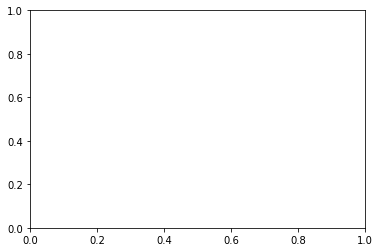

In [304]:
import time

simple = [784, 200, 10]
feeling = [784, 1568, 784, 196, 49, 10]
divide2 = [784, 392, 196, 98, 49, 10]

list_models = [simple, feeling, divide2]
list_lr = [0.01, 0.1, 0.005]
list_l2 = [0.001, 0.01, 0.005]

for e_model in list_models:
    for e_lr in list_lr:
        for e_l2 in list_l2:
            n1 = FCN(e_model, epochs=1000000, save_term=100000, l2=e_l2, lr=e_lr)
            n1.fit(x_train, y_train, x_val, y_val)
            print(f"model : {e_model}, lr:{e_lr}, l2:{e_l2}, best_acc = {np.max(n1.val_acc_log):>.8}")
            draw_acc(n1,True, f"result/{n1.last_saved_time}_acc.png", show=False)
            draw_err(n1, True, f"result/{n1.last_saved_time}_loss.png", show=False)
            